<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Index_Pairwise_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Index Pairwise Correlations
---
### Initialize the Workspace
This is done by bringing in a standard library package, which you can find here [my_library.py](https://github.com/Farmhouse121/Financial-Data-Science-in-Python/blob/main/my_library.py). This needs to be imported into the workspace of the project, and then executed. For brevity, we also turn off `UserWarning` and `FutureWarning`. You can skip that step if you want to.

In [ ]:
from my_library import *

17:55:55 Starting...
17:55:55 Installing yfinance into Google notebook...
17:56:04 Installing arch into Google notebook...
17:56:09 Initialized.


In [ ]:
# let's ignore some warnings that clutter the output, skip this cell if you want to see them
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

### Store Results in a DataFrame for Meta-Analysis

In [ ]:
try:
    meta=pd.read_pickle("/content/drive/MyDrive/meta.pickle")
    nprint("Read prior meta-analysis results from Google Drive.")

except:
    meta=pd.DataFrame({"Name":[],"N":[],"N*":[],"rho":[]}).set_index("Name")
    nprint("Created empty DataFrame for meta-analysis results.")

### Load List of Index Members
---
This has been set up to allow you to select one of the known indices by setting that value for `indexname`. In the future, more indices might be added via similar code branches.

In [18]:
nprint("Getting members of %s index." % (indexname:='Dow')) # choose from'Dow','S&P 500','NASDAQ-100','S&P MidCap 400','S&P SmallCap 600','S&P 900','S&P 1500'

def loadindex(indexname):
    """Load the specified index and return the members and the first date for data extraction."""

    if indexname=='S&P 500':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        first_date=index['Date added'].max() # add data is in table returned

    elif indexname=='NASDAQ-100':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4].set_index("Ticker"))
        first_date=datetime.now().strftime("%Y-01-02") # NASDAQ rebalances (normally) on the first day of the year. Jan'1st. is *always* a holiday

    elif indexname=='S&P MidCap 400':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        updates=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[1].set_index(("Date","Date"))
        updates.index=list(map(lambda x:pd.Period(x.split('[')[0],'D'),updates.index))
        first_date=str(updates.index.max())

    elif indexname=='S&P SmallCap 600':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        updates=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[1].set_index(("Date","Date"))
        updates.index=list(map(lambda x:pd.Period(x.split('[')[0],'D'),updates.index))
        first_date=str(updates.index.max())

    elif indexname=='S&P 900': # union of S&P 500 and S&P MidCap 400
        sp500,dt500=loadindex('S&P 500')
        sp400,dt400=loadindex('S&P MidCap 400')
        columns=list(set(sp500.columns).intersection(set(sp400.columns)))
        index=pd.concat([sp500[columns],sp400[columns]]).sort_index()
        first_date=max([dt500,dt400])

    elif indexname=='S&P 1500': # union of S&P 500, S&P MidCap 400, and S&P SmallCap 600
        sp900,dt900=loadindex('S&P 900')
        sp600,dt600=loadindex('S&P SmallCap 600')
        columns=list(set(sp900.columns).intersection(set(sp600.columns)))
        index=pd.concat([sp900[columns],sp600[columns]]).sort_index()
        first_date=max([dt900,dt600])

    elif indexname=='Dow': # Dow Jones
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        first_date=index['Date added'].max()

    else:
        raise ValueError("Don't know how to load members of %s Index!" % indexname)

    return index[~index.index.duplicated()],first_date # drop duplicates in case some exist

index,first_date=loadindex(indexname)
nprint("Total of %d stocks. First date for data extract is %s." % (index.shape[0],first_date))

12:30:42 Getting members of Dow index.


,Company,Exchange,Industry,Date added,Notes,Index weighting
Ticker,,,,,,
MMM,3M,NYSE,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,1.54%
AXP,American Express,NYSE,Financial services,1982-08-30,NaN,3.64%
AMGN,Amgen,NASDAQ,Biopharmaceutical,2020-08-31,NaN,4.80%
AMZN,Amazon,NASDAQ,Retailing,2024-02-26,NaN,2.93%
AAPL,Apple,NASDAQ,Information technology,2015-03-19,NaN,3.04%
BA,Boeing,NYSE,Aerospace and defense,1987-03-12,NaN,3.36%
CAT,Caterpillar,NYSE,Construction and mining,1991-05-06,NaN,5.45%
CVX,Chevron,NYSE,Petroleum industry,2008-02-19,Also 1930-07-18 to 1999-11-01,2.59%
CSCO,Cisco,NASDAQ,Information technology,2009-06-08,NaN,0.81%


12:30:42 Total of 30 stocks. First date for data extract is 2024-02-26.


### Measure Correlations for a Random Sample of Index Member Pairs
---
This analysis is survivorship bias free because data is taken strictly from the last portfolio rebalance only.

In [19]:
results=pd.DataFrame({"Trial":list(range(N:=5000)),"Ticker 1":[""]*N,"Ticker 2":[""]*N,"Correlation":[np.nan]*N,"Sample":[np.nan]*N}).set_index("Trial")

nprint("Getting daily data for all index stocks, starting on {:s}.".format(first_date))
data=download(list(map(lambda x:x.replace(".","-"),index.index)),first_date) # Yahoo! Finance uses - for subclasses of equity

for i in tqdm(results.index):
    df=data["Adj Close"].sample(2,axis=1)
    df.columns=pd.MultiIndex.from_product([["Adj Close"],df.columns])

    if df.shape[0]<10:
        continue

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Adj Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)
    df.index=pd.DatetimeIndex(df.index).to_period('D')
    results.loc[i,"Ticker 1"]=tickers[0]
    results.loc[i,"Ticker 2"]=tickers[1]
    results.loc[i,"Correlation"]=df["Return"].corr().iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]

results.set_index(["Ticker 1","Ticker 2"],inplace=True)
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
display(results)

12:30:47 Getting daily data for all index stocks, starting on 2024-02-26.


[*********************100%***********************]  30 of 30 completed


  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-19-f14c7a9c5a0e>:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Sample"]=results.shape[0]
<ipython-input-19-f14c7a9c5a0e>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())


,,Correlation,Sample
Ticker 1,Ticker 2,,
AXP,UNH,8.333979,140.0
CAT,HON,26.613568,140.0
UNH,MRK,-5.475289,140.0
NKE,GS,14.706217,140.0
AXP,HD,34.042326,140.0
...,...,...,...
PG,AMGN,13.536307,140.0
TRV,KO,22.424607,140.0
DOW,KO,15.313064,140.0


### Make a Histogram

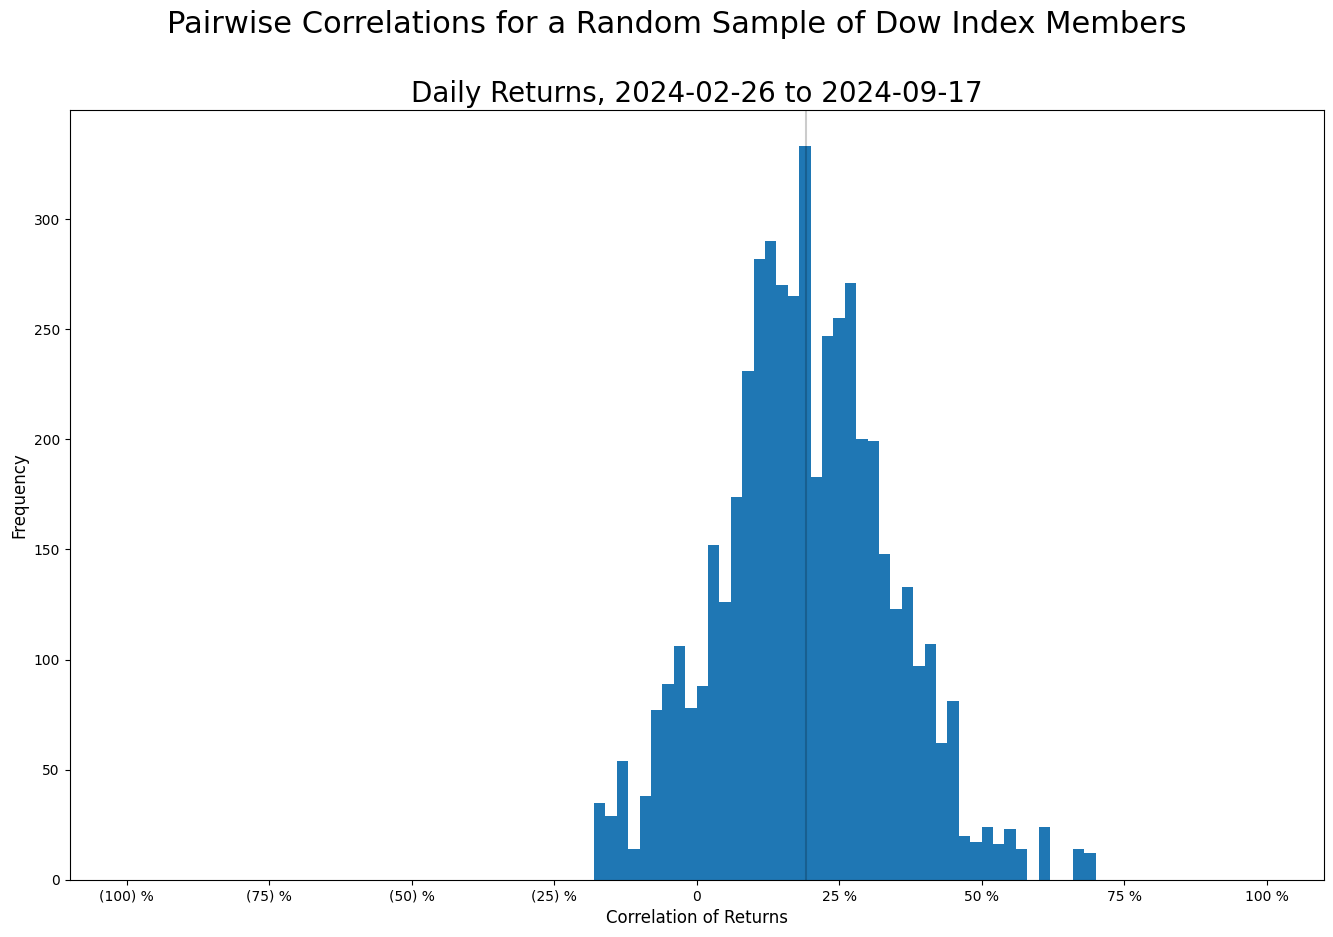

In [20]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
bins,counts,patches=plot.hist(results.loc[results.index!="Mean",'Correlation'].to_numpy(),bins=np.linspace(-hundred,hundred,101))
figure.suptitle(title:="Pairwise Correlations for a Random Sample of %s Index Members" % indexname,fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("Correlation of Returns",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(m,color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Execute the $N^*$ vs. $N$ Analysis
---
$N*$ is the effective degrees of freedom found within a portfolio of size $N$. This is computed by comparing the variance of the portfolio returns to the variance we would expect if all the stocks were independent.

In [21]:
results=pd.DataFrame({"Sample":range(1,(n:=1000)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*n}).set_index("Sample") # n is number of trials
nprint("Getting daily data for all index stocks, starting on %s." % first_date)
closes=data['Adj Close']
closes.index=pd.DatetimeIndex(closes.index).to_period('B')

nprint("Beginning analysis for {:,d} trials. This may take about {:.1f} minutes...".format(n,n/2.38/60)) # approx empirical timings

for i in tqdm(results.index): # for each trial, pick a random sample of stocks with portfolio sizes uniformly distributed between 1 and maximum, one of 2^503-1 choices
    returns=pd.DataFrame()

    for ticker in closes[np.random.choice(closes.columns,np.random.randint(1,closes.shape[1]+1),replace=False)]:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred # compute all adjusted returns, ticker by ticker

        if returns[ticker].shape[0]<1: # exclude time-series that are all NA's
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    results.loc[i,"Assets"]=returns.shape[1] # number of assets we ended up with
    results.loc[i,"Independent"]=returns.var().sum()/results.loc[i,"Assets"]**2 # if no correlation, portfolio variance is total variance divided by square of number of assets
    returns['Portfolio']=returns.mean(axis=1) # equal weighted portfolio return
    results.loc[i,"Portfolio"]=returns['Portfolio'].var() # variance of portfolio returns for same period as individual returns

results.dropna(inplace=True)
results["Effective D.o.F."]=results["Independent"]/results["Portfolio"]*results["Assets"]
display(results)
nprint("Done.")

12:33:40 Getting daily data for all index stocks, starting on 2024-02-26.
12:33:40 Beginning analysis for 1,000 trials. This may take about 7.0 minutes...


  0%|          | 0/1000 [00:00<?, ?it/s]

,Assets,Portfolio,Independent,Effective D.o.F.
Sample,,,,
1,5.0,0.955213,0.646792,3.385587
2,25.0,0.528286,0.108975,5.157031
3,12.0,0.462668,0.165171,4.283967
4,13.0,0.786196,0.261730,4.327784
5,12.0,0.456122,0.186491,4.906347
...,...,...,...,...
996,16.0,0.600259,0.163712,4.363780
997,7.0,0.431167,0.231707,3.761763
998,10.0,0.758330,0.372602,4.913459


12:34:11 Done.


### Make a Plot

12:37:17 Effective D.o.F. Limit 5.15, Implied Correlation 16.62 %.


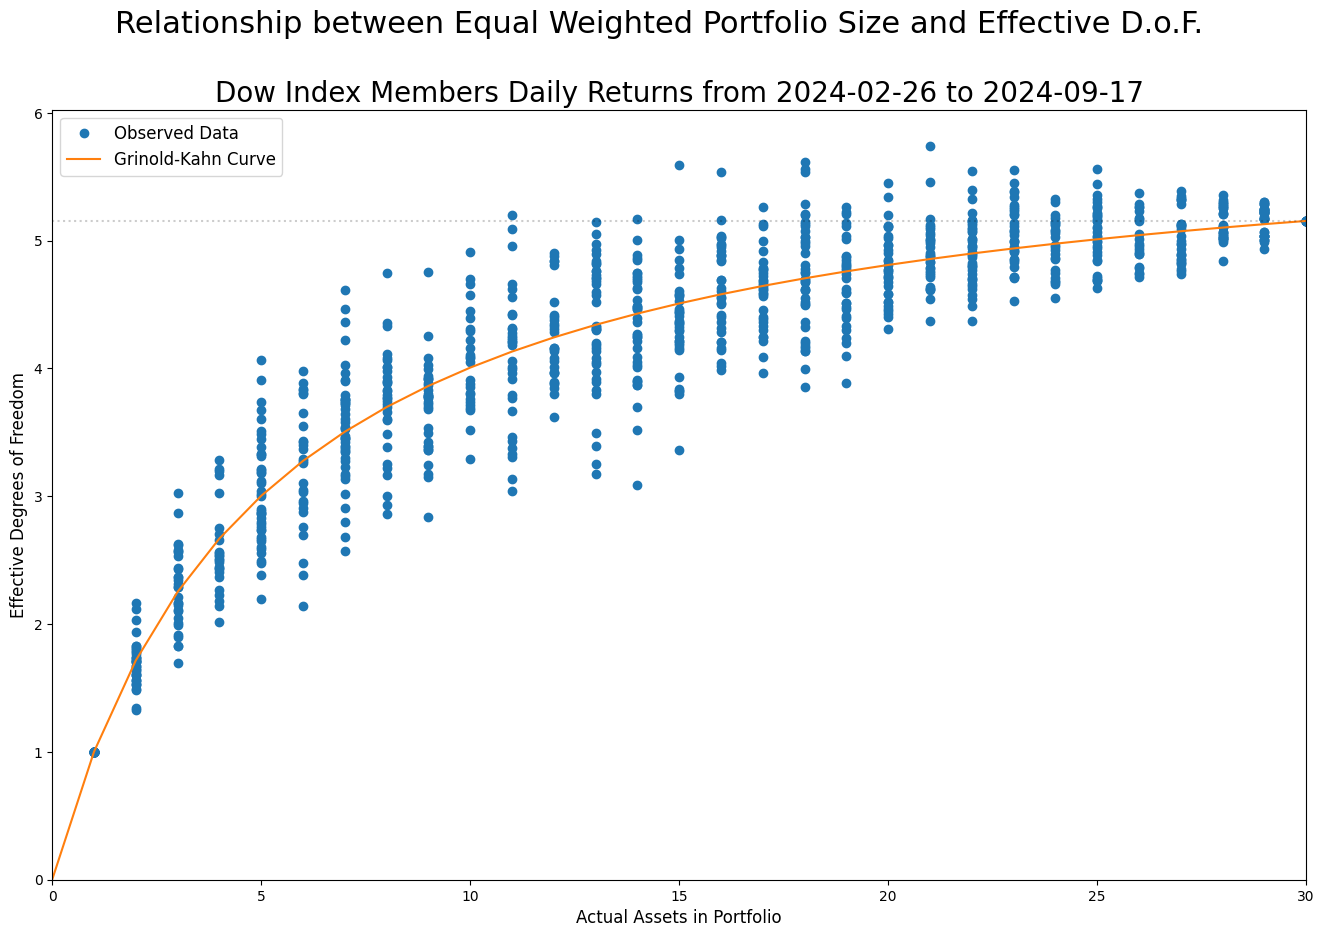

In [28]:
Nstar,Nact=tuple(results.sort_values("Assets").iloc[-1][["Effective D.o.F.","Assets"]])
rho=(Nact-Nstar)/((Nact-one)*Nstar)
nprint("Effective D.o.F. Limit {:,.2f}, Implied Correlation {:.2f} %.".format(Nstar,rho*hundred))
meta.loc[indexname,["N","N*","rho"]]=[Nact,Nstar,rho]

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=results["Assets"].to_numpy(),y:=results["Effective D.o.F."].to_numpy(),'o',label='Observed Data')
plot.plot(xp:=np.append([] if max(x)>100 else [zero],np.unique(np.sort(x))),xp/(one+(xp-one)*rho),'-',label='Grinold-Kahn Curve')
plot.set_xscale('log' if max(x)>100 else 'linear')
plot.set_ylim(zero,None)
plot.set_xlabel("Actual Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title:="Relationship between Equal Weighted Portfolio Size and Effective D.o.F.",fontsize=22)
plot.set_title("%s Index Members Daily Returns from %s to %s" % (indexname,first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)
plot.set_xlim(zero,index.shape[0])
plot.legend(fontsize=12)
plot.axhline(Nstar,color='black',linestyle=':',alpha=0.2)
plot.xaxis.set_major_formatter(CountLabels())
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Meta-Analysis
---

In [29]:
display(meta.sort_values("N",ascending=True))

try:
    meta.to_pickle("/content/drive/MyDrive/meta.pickle")
    nprint("Saved meta-analysis results to Google Drive.")

except:
    raise RuntimeError("You need to mount your Google Drive to save results.")

,N,N*,rho
Name,,,
Dow,30.0,5.154070,0.166229
NASDAQ-100,101.0,5.614945,0.169877
S&P MidCap 400,401.0,3.331481,0.298417
S&P 500,503.0,4.846194,0.204767
S&P SmallCap 600,602.0,3.415935,0.291569
S&P 900,904.0,3.898487,0.255686
S&P 1500,1504.0,4.004299,0.249232


12:41:05 Saved meta-analysis results to Google Drive.


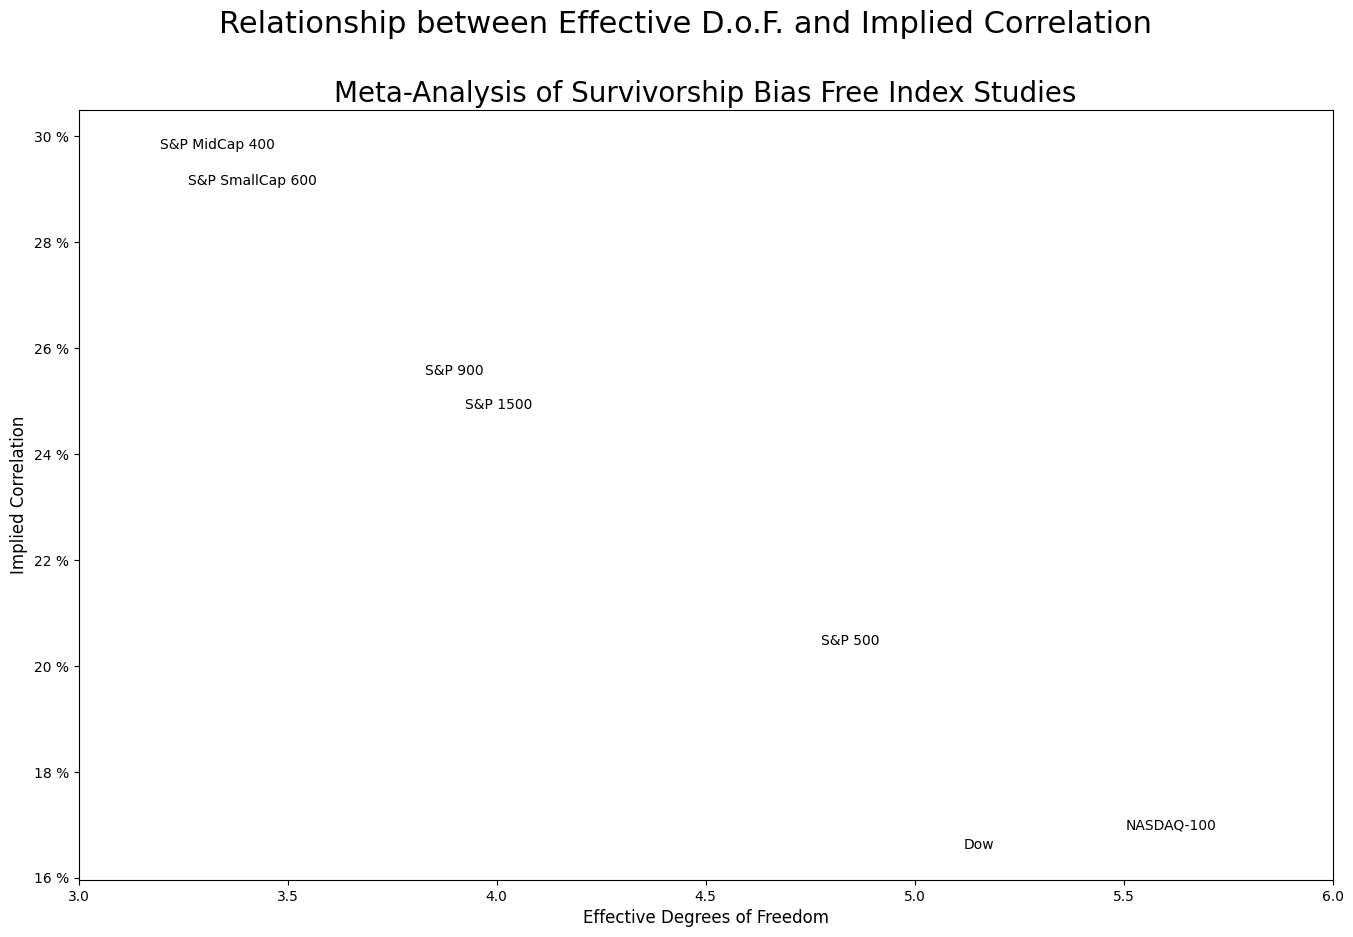

In [51]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=meta["N*"].to_numpy(),y:=meta["rho"].to_numpy()*hundred,'o',label='Observed Data',alpha=zero)
plot.set_xlabel("Effective Degrees of Freedom",fontsize=12)
plot.set_ylabel("Implied Correlation",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(0))
figure.suptitle(title:="Relationship between Effective D.o.F. and Implied Correlation",fontsize=22)
plot.set_title("Meta-Analysis of Survivorship Bias Free Index Studies",fontsize=20)
plot.set_xlim(np.floor(meta["N*"]).min(),np.ceil(meta["N*"]).max())

for i in meta.index:
    plot.text(x:=meta.loc[i,"N*"],y:=meta.loc[i,"rho"]*hundred,i,ha='center',va='center',fontsize=10)

figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### $\LaTeX$ Code for the Formulae in the Articles
---

$$
V_P=\mathbb{V}\!\left[\frac{1}{N}\sum_{i=1}^Nr_{it}\right]=\frac{1}{N^2}\mathbb{V}\!\left[\sum_{i=1}^Nr_{it}\right]
$$

$$
V_P=\frac{1}{N^2}\sum_{i=1}^N\sigma_i^2+\frac{2}{N^2}\sum_{i=1}^N\sum_{j=i+1}^N\sigma_i\sigma_j\rho_{ij}=V_I+V_C
$$

$$
V_I=\frac{1}{N}\left(\frac{1}{N}\sum_{i=1}^N\sigma_i^2\right)=\frac{\overline{\sigma^2}}{N}
$$

$$
\mathbb{V}[\bar{x}]=\frac{\sigma^2}{N}\;\mathrm{where}\;\mathbb{V}[x_i]=\mathbb{V}[x_j]=\sigma^2\;\mathrm{and}\;\mathbb{C}[x_i,x_j]=0\;\forall\;i,j
$$

$$
V_P=V_I\left(1+\frac{V_C}{V_I}\right)=\frac{\overline{\sigma^2}}{N}\left(1+\frac{V_C}{V_I}\right)
$$

$$
V_P=\frac{\overline{\sigma^2}}{N^*}\;\mathrm{where}\;N^*=N\frac{V_I}{V_P}
$$

$$
\sum_{N=1}^M\begin{pmatrix}M\\ N\end{pmatrix}=2^M-1
$$

$$
2^{503}-1\approx3.3\times10^{150}
$$

$$
\mathbb{V}[r_{it},r_{jt}]=\sigma_{it}\sigma_{jt}\rho\;\Leftrightarrow\;V=S_tRS_t\;\mathrm{where}\;R=\begin{pmatrix}
1&\rho&\cdots&\rho\\
\rho&1&\cdots&\rho\\
\vdots&&\ddots&\vdots\\
\rho&\rho&\cdots&1
\end{pmatrix}\;\mathrm{and}\;
S_t=\begin{pmatrix}
\sigma_{1t}&0&\cdots&0\\
0&\sigma_{2t}&\cdots&0\\
\vdots&&\ddots&\vdots\\
0&0&\cdots&\sigma_{Nt}
\end{pmatrix}
$$